# Counterparty Credit Risk Simulation using Monte Carlo: A Simplified Basel III Framework

# 1. Introduction and Regulatory Background

This project presents a Monte Carlo simulation framework for estimating counterparty credit exposure in a simplified derivatives portfolio. Specifically, we simulate the exposure profiles of two uncollateralized instruments—an Interest Rate Swap (IRS) and a Foreign Exchange Forward (FX Forward)—to calculate Expected Exposure (EE), Exposure at Default (EAD), and Risk-Weighted Assets (RWA) under regulatory assumptions.

## 1.1 Background: Counterparty Credit Risk (CCR)

Counterparty Credit Risk (CCR) refers to the risk that the counterparty to a financial contract may default before the final settlement of cash flows. Unlike traditional credit risk, CCR is **market-dependent**, since the exposure changes over time with the market value of the trade.

In the context of Basel III, banks are required to calculate and report several measures of Counterparty Credit Risk (CCR), including:

- **Expected Exposure (EE)**: The average future positive exposure at a specific time horizon, computed across simulated market paths. It serves as the foundational input for regulatory capital calculations.

- **Potential Future Exposure (PFE)**: A specified quantile (e.g., 95% or 97.5%) of the exposure distribution at each time point, reflecting the level of exposure that is only exceeded in a small percentage of extreme scenarios. PFE is often used to set internal credit limits and monitor tail risk.

- **Exposure at Default (EAD)**: An estimate of the exposure at the time of counterparty default. Under the Internal Model Method (IMM), EAD is typically computed as a discounted sum of EE values, multiplied by a regulatory factor (e.g., α = 1.4).

- **Risk-Weighted Assets (RWA)**: The regulatory capital base for CCR, calculated by applying risk weights to EAD. RWA feeds directly into minimum capital requirement calculations under Basel III.


## 1.2 Simulation Motivation

Unlike static metrics such as current MtM (mark-to-market), the future exposure of derivatives depends on simulated market paths (e.g., interest rates, exchange rates). Monte Carlo simulation is therefore a widely accepted approach for modeling EE and EAD under the **Internal Model Method (IMM)** framework.

The simulation aligns with practices outlined in:


- [Basel III Counterparty Credit Risk Framework](https://www.bis.org/publ/bcbs279.htm)
- [SR 11-7: Federal Reserve Guidance on Model Risk Management](https://www.federalreserve.gov/supervisionreg/srletters/sr1107.htm)

## 1.3 Project Objectives

The objectives of this project are:
1. **Simulate market paths** for interest rates and FX rates using simplified stochastic processes.
2. **Construct a two-product derivatives portfolio**: an IRS and an FX Forward.
3. **Calculate MtM and Exposure** along each simulated path.
4. **Aggregate across paths** to compute EE, PFE (optional), and EAD.
5. **Estimate regulatory capital** using simplified RWA formulas.

The framework is modular and extensible: additional instruments, collateral features, or risk factors may be added in future iterations to build a multi-product portfolio-level CCR engine.



# 2. Derivatives Portfolio and Assumptions

We construct a simplified derivatives portfolio consisting of two uncollateralized instruments: an Interest Rate Swap (IRS) and a Foreign Exchange Forward (FX Forward). Both trades are assumed to be entered at-the-money (i.e., initial MtM = 0) and evaluated under simulated market conditions.

## 2.1 Portfolio Instruments

### 2.1.1 Interest Rate Swap (IRS)

| Parameter              | Value                         |
|------------------------|-------------------------------|
| Notional               | USD 10,000,000                |
| Contract Type          | Pay Fixed / Receive Floating  |
| Fixed Rate             | 3.00% per annum               |
| Floating Rate Index    | 6M LIBOR                      |
| Maturity               | 2 years                       |
| Payment Frequency      | Semi-annual (T = 0.5, 1.0, 1.5, 2.0) |
| Collateral             | None (Uncollateralized)       |
| Initial MtM            | 0                             |

Although LIBOR has been discontinued for new contracts, it remains widely used in financial modeling and academic settings as a proxy for floating-rate exposure. In this project, we simulate 6M LIBOR paths to represent interest rate dynamics within a stylized swap framework.

### 2.1.2 Foreign Exchange Forward (FX Forward)

| Parameter                  | Value                     |
|----------------------------|---------------------------|
| Notional                   | EUR 5,000,000             |
| Spot Rate                  | 1.10 USD/EUR              |
| Forward Rate (contracted)  | 1.12 USD/EUR              |
| Maturity                   | 1 year                    |
| Collateral                 | None (Uncollateralized)   |
| Initial MtM                | 0                         |

This FX Forward represents a forward purchase of EUR against USD. At maturity, the MtM depends on the simulated spot FX rate relative to the agreed forward rate. Exposure arises when the spot rate exceeds the contracted rate.

### 2.1.3 Collateral Assumption

All instruments are assumed to be **uncollateralized**, meaning there is no exchange of variation margin to offset daily mark-to-market movements. As a result, any positive MtM directly translates into full counterparty credit exposure. In contrast, collateralized trades governed by Credit Support Annexes (CSAs) would reduce or eliminate exposure through margining. The uncollateralized setup reflects a worst-case scenario and simplifies the simulation framework.

---

## 2.2 Risk Factors and Simulation Horizon

To value the instruments and compute counterparty exposure, we simulate the following market risk factors:

| Risk Factor           | Description              | Simulation Horizon         |
|------------------------|---------------------------|----------------------------|
| Interest Rate          | 6M LIBOR rate             | 24 monthly steps (2 years) |
| FX Rate (USD/EUR)      | Spot exchange rate        | 12 monthly steps (1 year)  |

Both risk factors are simulated under a risk-neutral measure using geometric Brownian motion (GBM). For each factor, 1,000 Monte Carlo paths are generated to approximate the distribution of future exposure values.

---

## 2.3 Discounting and Regulatory Parameters

| Parameter                  | Assumption                                                   |
|----------------------------|--------------------------------------------------------------|
| Discounting Factor         | Derived from flat 3% risk-free rate                          |
| Regulatory Multiplier (`alpha`)  | `alpha = 1.4`, per Basel III IMM guidelines ([BCBS 279](https://www.bis.org/publ/bcbs279.htm)) |
| Risk Weight (RW)           | 50%, typical for interbank counterparties                    |

All exposure-related quantities (e.g., MtM, EE, EAD) are discounted using the formula:

    DF(t) = 1 / (1 + r)^t, where r = 3%

This aligns with simplified IMM-style frameworks, where discounted expected exposures form the basis for capital estimation.




# 3. Monte Carlo Simulation Framework

This section outlines the Monte Carlo simulation engine used to model the future evolution of market risk factors and compute the exposure of each instrument. We simulate forward-looking paths for 6M LIBOR and the USD/EUR spot rate, which drive the mark-to-market value of the Interest Rate Swap and FX Forward, respectively. These simulations form the basis for computing Expected Exposure (EE), Potential Future Exposure (PFE), Exposure at Default (EAD), and ultimately, Risk-Weighted Assets (RWA).

### 3.1 Simulating Market Risk Factors

To generate forward-looking market scenarios, we model both the 6M LIBOR and USD/EUR FX rate using **Geometric Brownian Motion (GBM)**. GBM is a widely used stochastic process in financial engineering that captures the log-normal evolution of asset prices or rates over time.

#### Geometric Brownian Motion (GBM)

The continuous-time stochastic differential equation for GBM is:

$$
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t
$$

where:
- $S_t$ is the value of the market variable at time $t$,
- $\mu$ is the drift term (average growth rate),
- $\sigma$ is the volatility (standard deviation of returns),
- $dW_t$ is an increment of a standard Brownian motion.

In discrete time with step size $\Delta t$, this process is approximated by:

$$
S_{t+\Delta t} = S_t \cdot \exp\left[\left(\mu - \frac{1}{2}\sigma^2\right)\Delta t + \sigma \sqrt{\Delta t} \cdot \varepsilon_t\right]
$$

where $\varepsilon_t \sim \mathcal{N}(0, 1)$ is a standard normal random variable.

#### Assumptions in This Project

- **Risk-neutral measure**: We assume $\mu = 0$ to reflect risk-neutral pricing, consistent with the valuation of derivatives.
- **Flat volatility**: Constant volatility $\sigma$ is used for both LIBOR and FX rates.
- **Monthly frequency**: Simulations are performed with monthly steps (i.e., $\Delta t = \frac{1}{12}$) to match regulatory exposure and capital reporting intervals.

> These simulated market paths serve as the foundation for computing path-dependent exposures, such as Expected Exposure (EE) and Potential Future Exposure (PFE), in later sections.


### 3.2 Simulated Market Paths

We generate simulated market paths for:

- **6M LIBOR** (used in the floating leg of the IRS)
- **USD/EUR FX rate** (used in FX Forward contract)

These paths are generated using the GBM formula described in Section 3.1, with monthly steps over the chosen horizon (e.g., 1–2 years) and 1,000 Monte Carlo paths per variable.

#### FX Rate Paths

The chart below shows a subset of the simulated USD/EUR FX rate paths. The initial spot rate is assumed to be 1.10, and the annualized volatility is set at 10%. For visual clarity, only the first 50 out of 1,000 paths are displayed.

> These forward-looking FX rates will later be used to compute the mark-to-market value of the FX Forward, which varies with currency fluctuations.

#### LIBOR Rate Paths

Similarly, the chart below displays simulated paths of the 6M LIBOR rate under a flat volatility assumption (e.g., 2% annualized). The LIBOR paths are used to compute the floating leg of the IRS.

> The stochastic evolution of interest rates directly influences exposure profiles, since IRS mark-to-market values depend on the difference between floating and fixed cash flows.


### 3.3 Exposure Calculation and Model Output

After simulating forward paths for the underlying market risk factors, we compute the **Mark-to-Market (MtM)** value of each instrument along each path. These MtM values allow us to assess the future credit exposure to the counterparty.

For each simulated path, we calculate:

- The **MtM value of the Interest Rate Swap (IRS)**, using the simulated LIBOR paths and a fixed contract rate.
- The **MtM value of the FX Forward**, using the simulated USD/EUR FX paths and a fixed forward rate.

Next, we derive the **exposure** by applying the following rule:

> \[
> \text{Exposure}_t = \max(\text{MtM}_t, 0)
> \]

This reflects that we are only exposed to counterparty default when the MtM is **positive** from our perspective (i.e., the counterparty owes us).

Finally, we aggregate exposures across all paths to generate:

- **Expected Exposure (EE)**: the average exposure at each future time point (e.g., each month);
- **Potential Future Exposure (PFE)**: the 97.5th percentile of exposure, capturing tail risk.

These quantities form the **exposure profile** or **exposure curve** over the life of the portfolio. They are crucial inputs for regulatory capital calculation and counterparty credit risk monitoring.


## 4. Exposure Metrics and Basel Capital Implication

### 4.1 Exposure Curve Visualization

This section defines and discusses the **Expected Exposure (EE)** and **Potential Future Exposure (PFE)**, which are core components in counterparty credit risk analysis.

- **EE** is calculated as the average of positive exposures across all simulation paths at each future time point.
- **PFE** is defined as the 97.5th percentile of the exposure distribution, capturing tail risk under a high confidence level.

> These metrics provide the exposure profile—or exposure curve—over time, and are foundational for computing Exposure at Default (EAD) and Risk-Weighted Assets (RWA) under Basel III.

The chart illustrating the EE and PFE curves is presented in the appendix, alongside additional model visualizations.


### 4.2 Basel III Capital Implication

Under the Basel III framework, banks are required to hold capital against **counterparty credit risk (CCR)** exposures arising from derivatives. The standardized approach defines **Exposure at Default (EAD)** as:

$$
\text{EAD} = \alpha \cdot \max(\text{EE})
$$

Where:
- $ \alpha = 1.4 $ is the **regulatory multiplier**, reflecting uncertainty in exposure estimation.
- $ \max(\text{EE}) $ is the **maximum expected exposure** across the life of the portfolio.

The **Risk-Weighted Assets (RWA)** for CCR are then computed using a regulatory risk weight $ RW $:

$$
\text{RWA} = \text{EAD} \cdot RW
$$

In this project, we apply a standardized **risk weight of 20%**, which is typical for investment-grade financial counterparties.

> This simplified framework allows us to translate exposure simulations into capital requirements, connecting market simulations with credit capital planning.


## 5. Conclusion

This project demonstrates a simplified yet practical approach to measuring **Counterparty Credit Risk (CCR)** exposure using Monte Carlo simulation techniques.

We constructed a small portfolio containing an **Interest Rate Swap (IRS)** and an **FX Forward**, and simulated their mark-to-market (MtM) values under stochastic market dynamics. From the simulated paths, we derived key exposure metrics:

- **Expected Exposure (EE)** as the average future credit exposure;
- **Potential Future Exposure (PFE)** as the 97.5th percentile of exposure distribution;
- **Exposure at Default (EAD)** using a regulatory multiplier;
- **Risk-Weighted Assets (RWA)** under Basel III standardized approach.

These metrics bridge **market risk modeling** with **credit capital implications**, highlighting how future exposure dynamics influence capital planning.

While the simulation model uses simplified assumptions (e.g., flat discount rate, no collateral, static positions), it offers a scalable framework for introducing more realistic features such as collateralization, netting sets, or stress scenario overlays.

> Future extensions may incorporate multiple counterparties, collateral agreements (CSA), and advanced stochastic models (e.g., Hull-White for interest rates), aligning the simulation more closely with regulatory expectations and industry practice.


## Appendix

This section provides all simulation code and output charts used in the project. Key charts are annotated for clarity. Function definitions are included for reproducibility, without line-by-line explanation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
## gbm simulation
def simulate_gbm_paths(S0, mu, sigma, T, steps, n_paths, seed=None):
    """
    Simulate geometric Brownian motion paths.
    
    Parameters:
        S0 (float): Initial value
        mu (float): Drift (annualized)
        sigma (float): Volatility (annualized)
        T (float): Time horizon in years
        steps (int): Number of time steps
        n_paths (int): Number of simulated paths
        seed (int, optional): Random seed for reproducibility
    
    Returns:
        np.ndarray: Simulated paths of shape (n_paths, steps + 1)
    """
    if seed is not None:
        np.random.seed(seed)
        
    dt = T / steps
    paths = np.zeros((n_paths, steps + 1))
    paths[:, 0] = S0
    
    for t in range(1, steps + 1):
        Z = np.random.normal(0, 1, n_paths)
        paths[:, t] = paths[:, t - 1] * np.exp(
            (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
        )
        
    return paths


In [3]:
def compute_product_mtm(paths, contract_rate, notional, discount_rate,
                        payment_freq_months=6, step_unit=12, direction="payer"):
    """
    Compute the Mark-to-Market (MtM) value of a derivative product (e.g., IRS or FX Forward)
    assuming contract-based vs. simulated (market) rate structure with regular payments.

    Parameters:
    - paths: ndarray of shape (n_paths, n_steps), simulated forward rates or FX paths
    - contract_rate: float, the agreed contractual rate (e.g., fixed swap rate or FX forward rate)
    - notional: float, notional amount
    - discount_rate: float, flat discount rate used for all payments
    - payment_freq_months: int, frequency of payment in months (default = 6)
    - step_unit: int, number of simulation steps per year (e.g., 12 = monthly)
    - direction: str, "payer" or "receiver"
        - "payer" means we pay fixed and receive floating (exposure arises when market > contract)
        - "receiver" means we receive fixed and pay floating (exposure arises when market < contract)

    Returns:
    - mtm_paths: ndarray of MtM values for each path
    """
    n_paths, n_steps = paths.shape
    total_months = n_steps
    payment_times = np.arange(payment_freq_months, total_months + 1, payment_freq_months)
    payment_years = payment_times / step_unit
    discount_factors = 1 / (1 + discount_rate) ** payment_years

    period_length = payment_freq_months / 12  # Payment interval in years

    mtm_paths = np.zeros(n_paths)
    for i in range(n_paths):
        path = paths[i]
        market_rate = path[payment_times - 1]
        contract_cashflows = contract_rate * notional * period_length
        floating_cashflows = market_rate * notional * period_length

        if direction == "payer":
            net_cashflows = floating_cashflows - contract_cashflows
        elif direction == "receiver":
            net_cashflows = contract_cashflows - floating_cashflows
        else:
            raise ValueError("direction must be either 'payer' or 'receiver'")

        mtm = np.sum(net_cashflows * discount_factors)
        mtm_paths[i] = mtm

    return mtm_paths


In [4]:
# Parameters for LIBOR simulation (assumed already completed)
S0_libor = 0.03          # Initial LIBOR rate
mu_libor = 0.0           # Risk-neutral drift
sigma_libor = 0.01       # Annual volatility
T_libor = 2              # 2-year horizon
steps_libor = 24         # Monthly steps over 2 years
n_paths = 1000           # Number of simulation paths

np.random.seed(42)

# Simulate LIBOR paths
libor_paths = simulate_gbm_paths(S0=S0_libor, mu=mu_libor, sigma=sigma_libor,
                                 T=T_libor, steps=steps_libor, n_paths=n_paths)




### A.1 LIBOR Rate Paths and IRS MtM

**Chart: IRS MtM Distribution**

> Simulated mark-to-market (MtM) values for a fixed-for-floating Interest Rate Swap (IRS).  
> - Simulated paths: 6M LIBOR using Geometric Brownian Motion  
> - Notional: $1,000,000  
> - Fixed rate: 1.12  
> - Simulation: Monthly over 1 year (12 steps), 1,000 paths

**Path:**  
`irs_paths = simulate_gbm_paths(S0=0.012, mu=0.0, sigma=0.01, T=1, steps=12, n_paths=1000)`

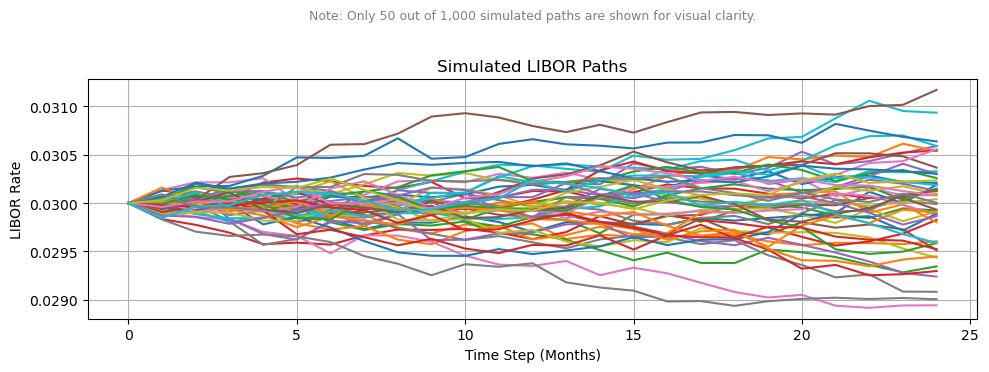

In [5]:
# Plot sample FX paths
plt.figure(figsize=(10, 4))
plt.plot(libor_paths[:50].T)
plt.title("Simulated LIBOR Paths")
plt.xlabel("Time Step (Months)")
plt.ylabel("LIBOR Rate")
plt.grid(True)

# Add note as text on the plot
plt.text(0.5, 1.25, "Note: Only 50 out of 1,000 simulated paths are shown for visual clarity.",
         transform=plt.gca().transAxes, fontsize=9, color="gray", ha="center")

plt.tight_layout()
plt.show()

**MtM Function:**  
`mtm_irs = compute_product_mtm(irs_paths, fixed_rate=0.0112, notional=1_000_000, discount_rate=0.03)`


In [6]:
# Call function for IRS
mtm_irs = compute_product_mtm(libor_paths, contract_rate=0.03, notional=1_000_000, discount_rate=0.03, direction="payer") 

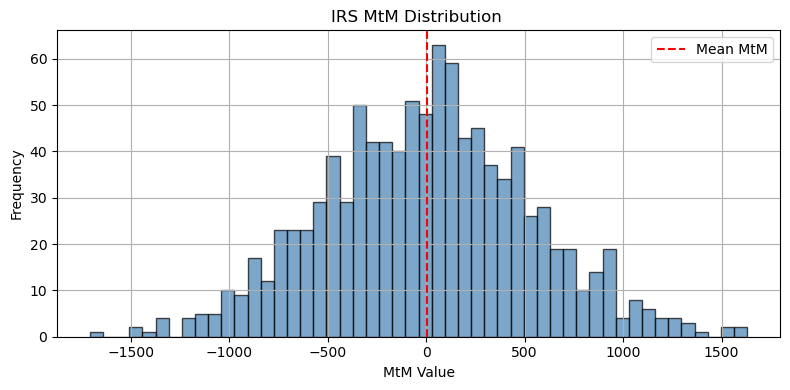

In [7]:
# Plot
plt.figure(figsize=(8, 4))
plt.hist(mtm_irs, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(np.mean(mtm_irs), color='red', linestyle='--', label='Mean MtM')
plt.title("IRS MtM Distribution ")
plt.xlabel("MtM Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### A.2 FX Rate Paths and FX Forward MtM

**Chart: FX Forward MtM Distribution**

> Simulated MtM values for a USD/EUR FX Forward.  
> - Spot rate: 1.10  
> - Forward rate: 1.12  
> - Annual volatility: 10%  
> - Simulation: Monthly over 1 year (12 steps), 1,000 paths

**Path:**  
`fx_paths = simulate_gbm_paths(S0=1.1, mu=0.0, sigma=0.10, T=1, steps=12, n_paths=1000)`

In [8]:
# Parameters for FX rate simulation (USD/EUR)
S0_fx = 1.1             # Initial FX rate
mu_fx = 0.0             # Risk-neutral drift
sigma_fx = 0.10         # Annual volatility (10%)
T_fx = 1                # Time horizon: 1 year
steps_fx = 12           # Monthly steps
n_paths = 1000          # Number of simulation paths

# Simulate FX paths
fx_paths = simulate_gbm_paths(S0=S0_fx, mu=mu_fx, sigma=sigma_fx,
                              T=T_fx, steps=steps_fx, n_paths=n_paths, seed=42)
mtm_fx = compute_product_mtm(fx_paths, contract_rate=1.12, notional=1_000_000, discount_rate= 0.03, direction="payer")

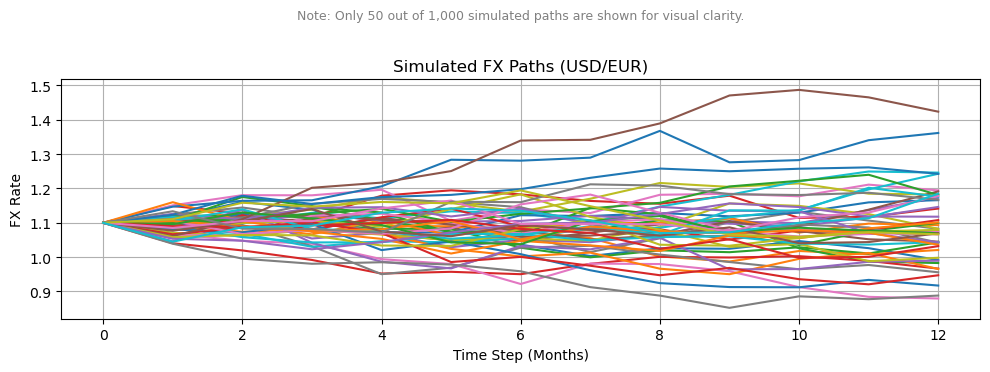

In [9]:
# Plot sample FX paths
plt.figure(figsize=(10, 4))
plt.plot(fx_paths[:50].T)
plt.title("Simulated FX Paths (USD/EUR)")
plt.xlabel("Time Step (Months)")
plt.ylabel("FX Rate")
plt.grid(True)

# Add note as text on the plot
plt.text(0.5, 1.25, "Note: Only 50 out of 1,000 simulated paths are shown for visual clarity.",
         transform=plt.gca().transAxes, fontsize=9, color="gray", ha="center")

plt.tight_layout()
plt.show()

**MtM Function:**  
`mtm_fx = compute_product_mtm(fx_paths, fixed_rate=1.12, notional=1_000_000, discount_rate=0.03)`


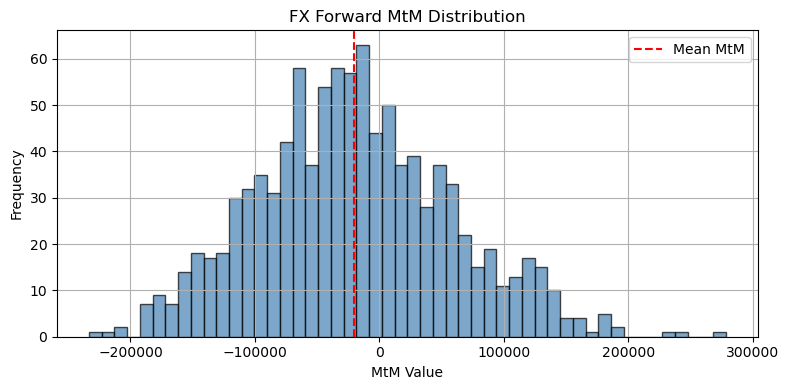

In [10]:
plt.figure(figsize=(8, 4))
plt.hist(mtm_fx, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(np.mean(mtm_fx), color='red', linestyle='--', label='Mean MtM')
plt.title("FX Forward MtM Distribution")
plt.xlabel("MtM Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
def calculate_exposure_curve(mtm_matrix, pfe_quantile=97.5):
    """
    Compute Expected Exposure (EE) and Potential Future Exposure (PFE) curves from MtM matrix.

    Parameters:
    - mtm_matrix: ndarray of shape (n_paths, n_steps), simulated MtM values for each product and path
    - pfe_quantile: float, quantile level for PFE (e.g., 97.5 for Basel default)

    Returns:
    - ee_curve: ndarray of expected exposure at each time step
    - pfe_curve: ndarray of quantile exposure at each time step
    """
    # Only consider positive MtM values as exposure (negative = no counterparty risk)
    positive_exposure = np.maximum(mtm_matrix, 0)

    # EE: mean exposure across all paths
    ee_curve = np.mean(positive_exposure, axis=0)

    # PFE: specified quantile across all paths
    pfe_curve = np.percentile(positive_exposure, pfe_quantile, axis=0)

    return ee_curve, pfe_curve

In [12]:
def calculate_ead_rwa(ee_curve, alpha=1.4, risk_weight=0.2):
    """
    Compute EAD and RWA under Basel III standardized approach.

    Parameters:
    - ee_curve: ndarray of expected exposure values
    - alpha: float, regulatory multiplier (default = 1.4)
    - risk_weight: float, standardized risk weight (default = 20%)

    Returns:
    - ead: Exposure at Default
    - rwa: Risk-Weighted Asset amount
    """
    ead = alpha * np.max(ee_curve)
    rwa = ead * risk_weight
    return ead, rwa

In [13]:
ee_irs = calculate_exposure_curve(mtm_irs)[0]
pfe_irs = calculate_exposure_curve(mtm_irs)[1]

ead_irs = calculate_ead_rwa(ee_irs)[0]
rwa_irs = calculate_ead_rwa(ee_irs)[1]

In [14]:
ee_fx = calculate_exposure_curve(mtm_fx)[0]
pfe_fx = calculate_exposure_curve(mtm_fx)[1]

ead_fx = calculate_ead_rwa(ee_fx)[0]
rwa_fx = calculate_ead_rwa(ee_fx)[1]

In [15]:
ead_total = ead_irs + ead_fx
rwa_total = rwa_irs + rwa_fx

### A.3 Capital Summary

**Table: Basel III Capital Requirement**

In [16]:
capital_metrics_df = pd.DataFrame({
    "Metric": ["EAD (IRS)", "EAD (FX)", "EAD (Total)", "RWA (IRS)", "RWA (FX)", "RWA (Total)"],
    "USD (million)": [ead_irs, ead_fx, ead_total, rwa_irs, rwa_fx, rwa_total]
})

capital_metrics_df

,Metric,USD (million)
0,EAD (IRS),296.185664
1,EAD (FX),31526.533049
2,EAD (Total),31822.718713
3,RWA (IRS),59.237133
4,RWA (FX),6305.306610
5,RWA (Total),6364.543743
